In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D
import warnings
import sys

# Optional: Suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore", DeprecationWarning)


In [4]:
# Define place
place = "Islamabad, Pakistan"

# 1. Get the boundary of Islamabad
boundary = ox.geocode_to_gdf(place)

# 2. Get POIs
tags = {
    'amenity': ['hospital', 'university', 'college', 'marketplace'],
    'shop': ['supermarket']
}
pois = ox.features_from_place(place, tags)


In [5]:
# 3. Filter POIs
hospitals = pois[pois['amenity'] == 'hospital']
universities = pois[pois['amenity'].isin(['university', 'college'])]
markets = pois[(pois['amenity'] == 'marketplace') | (pois['shop'] == 'supermarket')]

# 4. Roads data
G = ox.graph_from_place(place, network_type='drive')
roads = ox.graph_to_gdfs(G, nodes=False, edges=True)
major_roads = roads[roads['highway'].isin(['primary', 'secondary'])]


/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/sm

In [6]:
# 5. Reproject all to EPSG:3857 for web maps
boundary = boundary.to_crs(epsg=3857)
hospitals = hospitals.to_crs(epsg=3857)
universities = universities.to_crs(epsg=3857)
markets = markets.to_crs(epsg=3857)
major_roads = major_roads.to_crs(epsg=3857)


/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/sm

/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/h

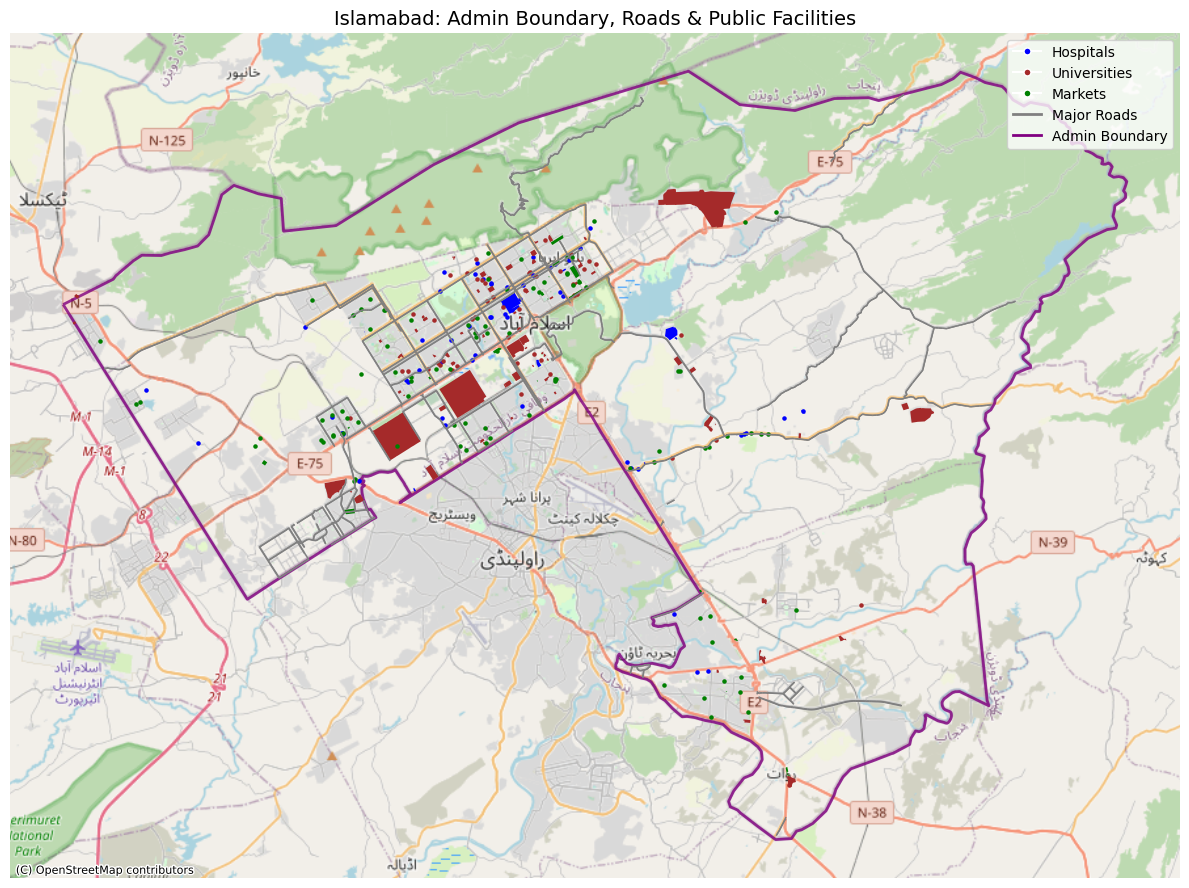

In [7]:
# 6. Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # bigger figure size

# Plot boundary first (purple)
boundary.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, alpha=0.8)

# Plot major roads and POIs
major_roads.plot(ax=ax, linewidth=1, edgecolor='gray')
hospitals.plot(ax=ax, color='blue', markersize=5)
universities.plot(ax=ax, color='brown', markersize=5)
markets.plot(ax=ax, color='green', markersize=5)

# # Set manual zoom to full boundary extent
# xmin, ymin, xmax, ymax = boundary.total_bounds
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# Basemap
ctx.add_basemap(ax, crs=boundary.crs, source=ctx.providers['OpenStreetMap']['Mapnik'])

# Updated legend (purple line added)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Hospitals', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Universities', markerfacecolor='brown', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Markets', markerfacecolor='green', markersize=5),
    Line2D([0], [0], color='gray', lw=2, label='Major Roads'),
    Line2D([0], [0], color='purple', lw=2, label='Admin Boundary')
]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("Islamabad: Admin Boundary, Roads & Public Facilities", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/sm

OverflowError: cannot convert float infinity to integer

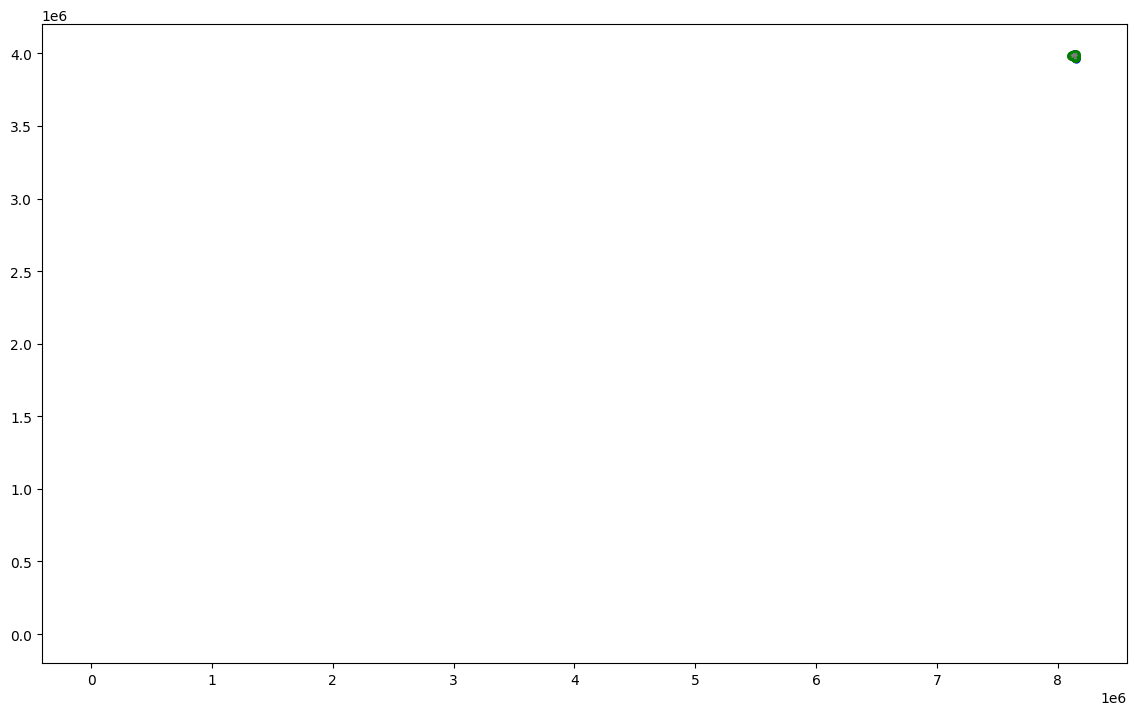

In [10]:
metro_routes = gpd.read_file("metro-data/islamabad_sections.geojson")

# 6. Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # bigger figure size

# Plot boundary first (purple)
boundary.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, alpha=0.8)

# Plot major roads and POIs
major_roads.plot(ax=ax, linewidth=1, edgecolor='gray')
hospitals.plot(ax=ax, color='blue', markersize=5)
universities.plot(ax=ax, color='brown', markersize=5)
markets.plot(ax=ax, color='green', markersize=5)

metro_routes.plot(ax=ax, linewidth=2.5, edgecolor='purple', label='Metro Bus Routes')

# # Set manual zoom to full boundary extent
# xmin, ymin, xmax, ymax = boundary.total_bounds
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# Basemap
ctx.add_basemap(ax, crs=boundary.crs, source=ctx.providers['OpenStreetMap']['Mapnik'])

# Updated legend (purple line added)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Hospitals', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Universities', markerfacecolor='brown', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Markets', markerfacecolor='green', markersize=5),
    Line2D([0], [0], color='gray', lw=2, label='Major Roads'),
    Line2D([0], [0], color='purple', lw=2, label='Admin Boundary')
    Line2D([0], [0], color='purple', lw=2, label='Metro bus routes')

]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("Islamabad: Admin Boundary, Roads & Public Facilities", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [8]:
# Define buffer distance in meters (adjust as needed)
buffer_dist = 1000  # 1 km

# Project to a metric CRS for accurate buffering (e.g., UTM)
hospitals_proj = hospitals.to_crs(epsg=32643)       # Islamabad UTM zone
universities_proj = universities.to_crs(epsg=32643)
markets_proj = markets.to_crs(epsg=32643)

# Create buffers
hosp_buffers = hospitals_proj.buffer(buffer_dist)
uni_buffers = universities_proj.buffer(buffer_dist)
market_buffers = markets_proj.buffer(buffer_dist)

# Convert back to GeoDataFrames for later use
hosp_buffers = gpd.GeoDataFrame(geometry=hosp_buffers, crs=hospitals_proj.crs)
uni_buffers = gpd.GeoDataFrame(geometry=uni_buffers, crs=universities_proj.crs)
market_buffers = gpd.GeoDataFrame(geometry=market_buffers, crs=markets_proj.crs)


/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/smirfan/miniconda3/envs/spatial_env/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [9]:
import networkx as nx

# Find nearest network nodes to hospitals and universities
orig_node = ox.distance.nearest_nodes(G, X=hospitals.geometry.x.iloc[0], Y=hospitals.geometry.y.iloc[0])
dest_node = ox.distance.nearest_nodes(G, X=universities.geometry.x.iloc[0], Y=universities.geometry.y.iloc[0])

# Get the shortest path between them
route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Plot it
fig, ax = ox.plot_graph_route(G, route, route_linewidth=4, node_size=0, bgcolor='white')


ValueError: x attribute access only provided for Point geometries